In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sys

sys.path.append(os.path.abspath("../"))
from dataset import DS_NAMES
from dataset import DS_DIMENSIONS
from utilities.figure_tools import get_latest_results_directory, make_fig_directory, load_results

cmap = plt.get_cmap("Set1")
colors = cmap.colors

results_path = "../results/vary-ntrees/vary_ntrees.csv"
output_dir = "./"


In [121]:
all_results = pd.read_csv(results_path).groupby(["dataset", "explainer", "n_trees"]).mean().reset_index()
found_ds = list(all_results["dataset"].unique())
all_results.head()

,dataset,explainer,n_trees,iteration,max_depth,accuracy,precision,recall,f1,per_valid,avg_dist,avg_length,prep_time,explain_time,sample_time,n_explain
0,cancer,FACETIndex,10,1.0,5.0,0.938596,0.965517,0.823529,0.888889,1.0,0.134902,4.55,17.812557,1.680000,0.08400,20.0
1,cancer,FACETIndex,50,1.0,5.0,0.947368,0.937500,0.882353,0.909091,1.0,0.281169,10.40,51.925910,5.290000,0.26450,20.0
2,cancer,OCEAN,10,1.0,5.0,0.947368,0.966667,0.852941,0.906250,1.0,0.113525,3.90,0.000000,0.993001,0.04965,20.0
3,cancer,OCEAN,50,1.0,5.0,0.947368,0.937500,0.882353,0.909091,1.0,0.153317,7.60,0.000000,6.864000,0.34320,20.0
4,glass,FACETIndex,10,1.0,5.0,0.818182,0.789474,0.882353,0.833333,1.0,0.072734,2.20,8.616122,0.076000,0.00380,20.0


In [122]:
for expl in all_results["explainer"].unique():
    print(expl)

FACETIndex
OCEAN


In [123]:
def render_plot(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False, lloc=None):

    for ds in all_results["dataset"].unique():
        plt.figure()
        is_ds = all_results["dataset"] == ds
        for expl in all_results["explainer"].unique():
            is_expl = all_results["explainer"] == expl
            matching_rows = is_ds & is_expl
            plt.plot(all_results[matching_rows][xfeature], all_results[matching_rows][yfeature], label=expl, lw=2.0)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend(loc="best")
        if xrange is not None:
            plt.xlim(xrange)
        if yrange is not None:
            plt.ylim(yrange)
        if save_name is not None:
            plt.savefig(output_dir + ds + save_name, bbox_inches="tight")

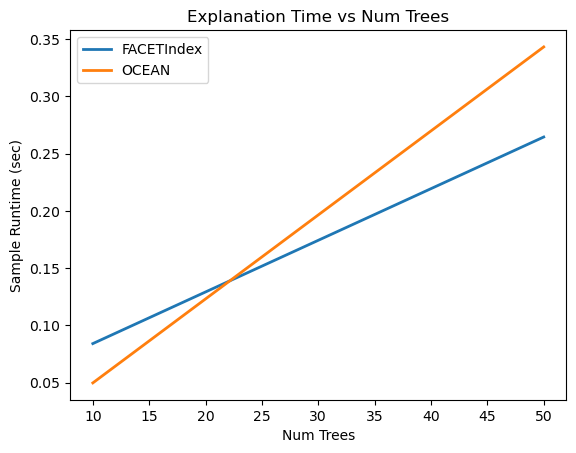

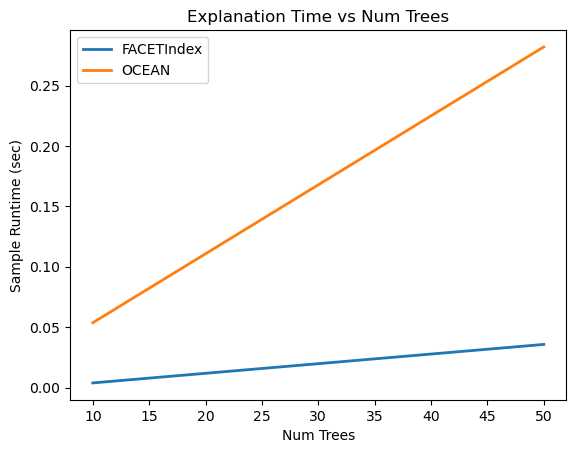

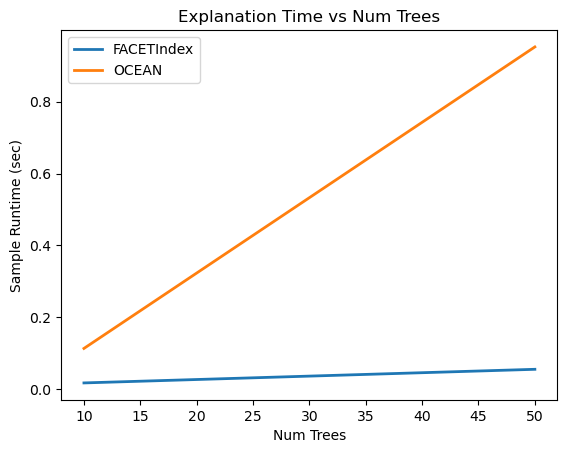

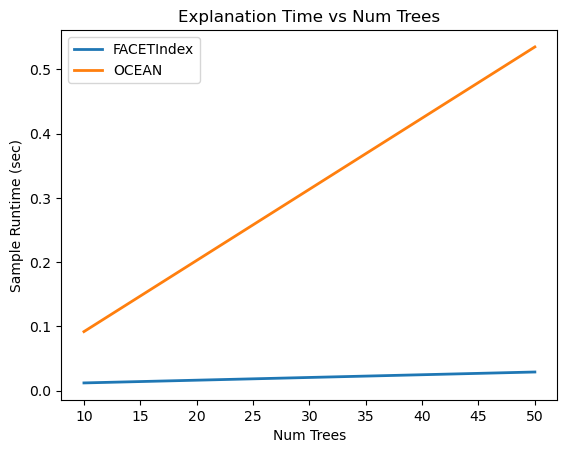

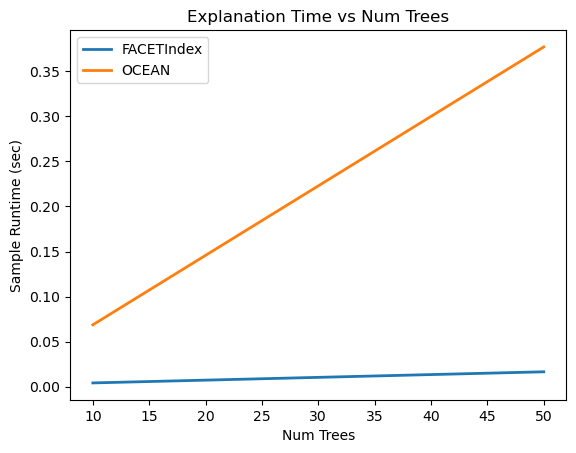

In [124]:
# sample time vs number of trees
render_plot("n_trees", "sample_time", "Num Trees", "Sample Runtime (sec)", "Explanation Time vs Num Trees", save_name=None)

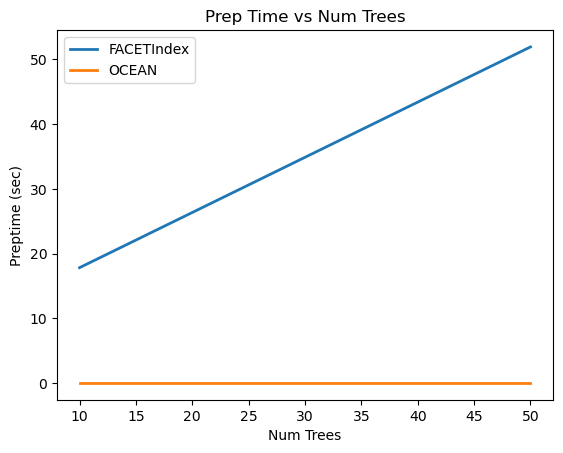

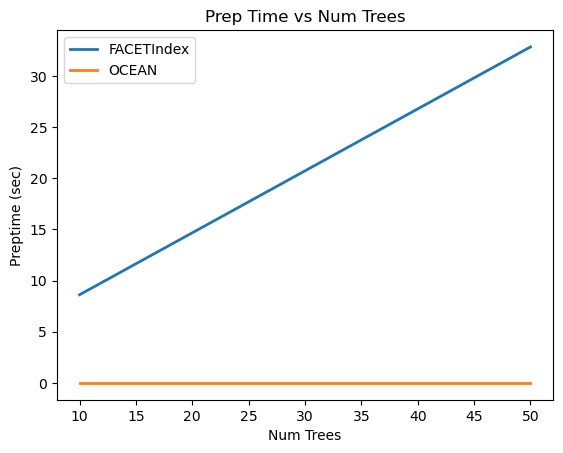

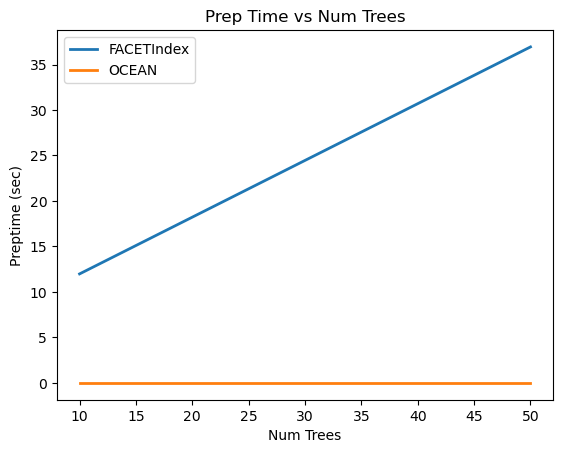

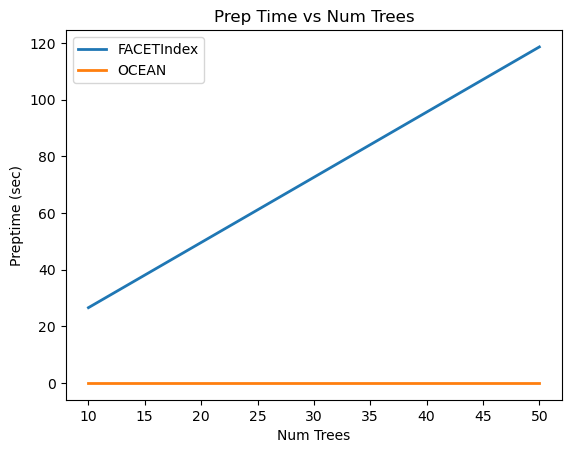

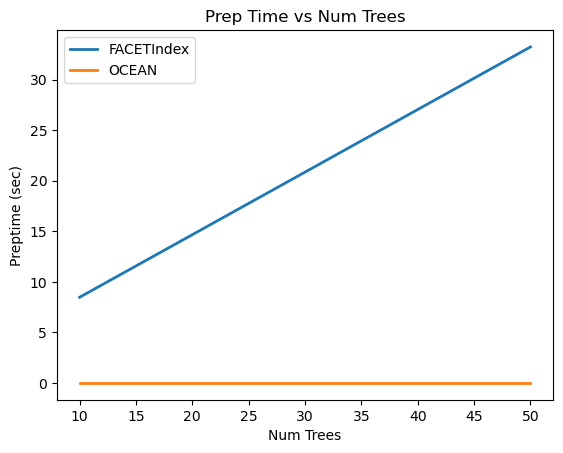

In [125]:
# prep time vs number of trees
render_plot("n_trees", "prep_time", "Num Trees", "Preptime (sec)", "Prep Time vs Num Trees", save_name=None)

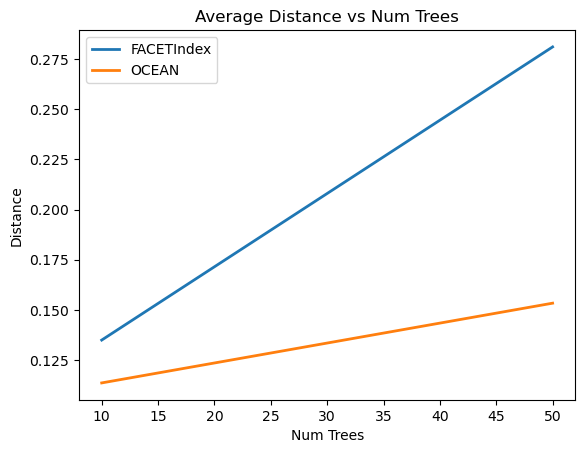

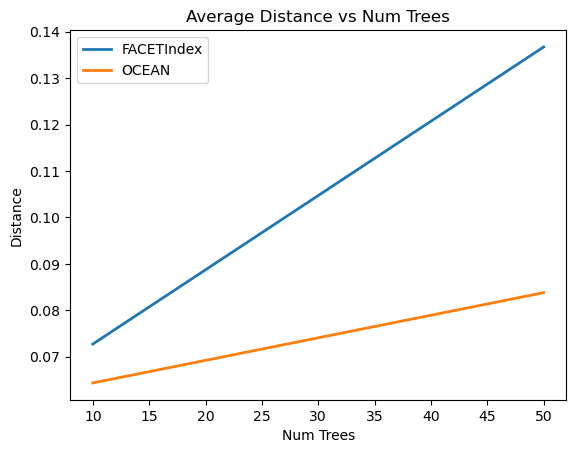

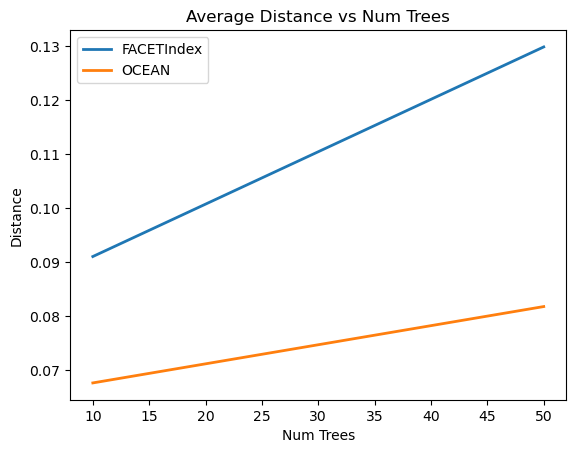

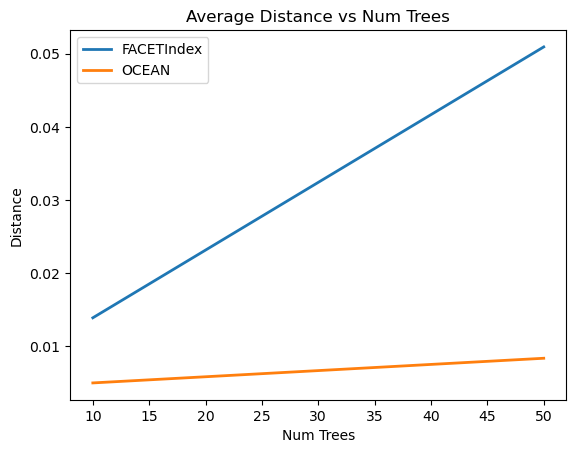

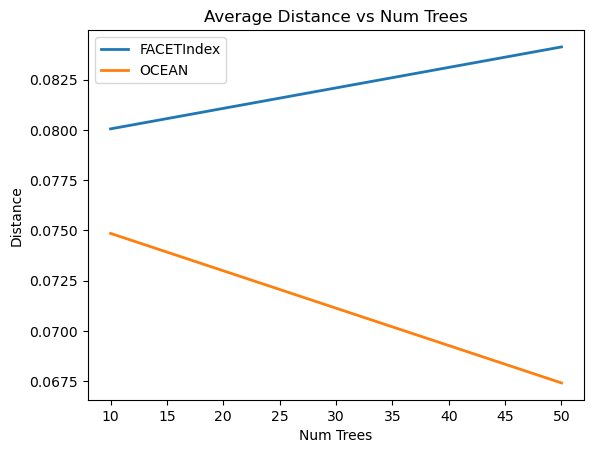

In [126]:
# prep time vs number of trees
render_plot("n_trees", "avg_dist", "Num Trees", "Distance", "Average Distance vs Num Trees", save_name=None)